In [580]:
%run ../../resources/resources.ipynb

In [581]:
# load geometries
with open('MainFoil_N=100.csv', 'r') as infile:
    x_main, y_main = np.loadtxt(infile, delimiter=',', dtype=float, unpack=True)
    
with open('FlapFoil_N=100.csv', 'r') as infile:
    x_flap, y_flap = np.loadtxt(infile, delimiter=',', dtype=float, unpack=True)

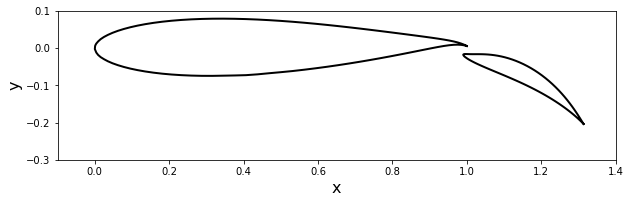

In [582]:
# plot
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box');
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.1);

In [583]:
# discretize main
N = 100
panels_main = define_panels(x_main, y_main, N)

# flap discretization
## find chord center
x_min = np.unravel_index(x_flap)

panels = np.append(panels_main, panels_flap)

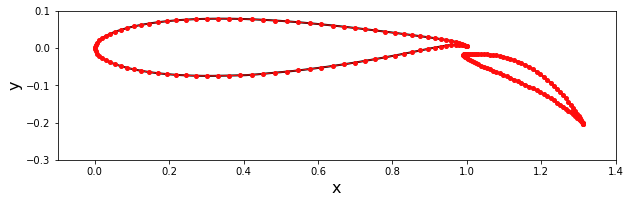

In [584]:
# plot
width = 10
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.plot([panel.xc for panel in panels[:len(panels_main)]], [panel.yc for panel in panels[:len(panels_main)]],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.plot([panel.xc for panel in panels[len(panels_flap):]], [panel.yc for panel in panels[len(panels_flap):]],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.axis('scaled', adjustable='box');
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.1);

In [585]:
# free stream
fs = Freestream()

In [586]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + np.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - np.sin(panel.beta)*s))**2
                   +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [587]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [588]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [589]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty([2, A_source.shape[1]+2], dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[0, :-2] = B_vortex[0, :] - B_vortex[A_source.shape[0]/2-1, :]
    b[1, :-2] = B_vortex[A_source.shape[0]/2, :] - B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[0, -2] = np.sum(A_source[0, :A_source.shape[1]/2] - A_source[A_source.shape[0]/2-1, :A_source.shape[1]/2])
    b[0, -1] = np.sum(A_source[0, A_source.shape[1]/2:] - A_source[A_source.shape[0]/2-1, A_source.shape[1]/2:])
    b[1, -2] = np.sum(A_source[A_source.shape[0]/2, :A_source.shape[1]/2] - A_source[-1, :A_source.shape[1]/2])
    b[1, -1] = np.sum(A_source[A_source.shape[0]/2, A_source.shape[1]/2:] - A_source[-1, A_source.shape[0]/2:])
    return b

In [590]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = -np.sum(B_vortex[:, :B_vortex.shape[0]/2], axis=1)
    A[:-2, -1] = -np.sum(B_vortex[:, B_vortex.shape[0]/2:], axis=1)
    # Kutta condition array
    b = kutta_condition(A_source, B_vortex)
    A[-2, :] = b[0, :]
    A[-1, :] = b[1, :]
    return A

In [591]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels[:len(panels)/2]):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    for i, panel in enumerate(panels[len(panels)/2:]):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha + np.pi/6 - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf*( np.sin(freestream.alpha-panels[0].beta)
                               -np.sin(freestream.alpha-panels[len(panels)/2-1].beta) )
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha+np.pi/6-panels[len(panels)/2].beta)
                               -np.sin(freestream.alpha+np.pi/6-panels[-1].beta) )
    return b

In [592]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [593]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, fs)

/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__

In [594]:
strengths = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = strengths[i]

gamma_main = strengths[-2]
gamma_flap = strengths[-1]
gamma = np.append(gamma_main, gamma_flap)

In [595]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels.size, panels.size+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same as
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -np.sum(A_source[:, :len(panels)/2], axis=1)
    A[:, -1] = -np.sum(A_source[:, (len(panels)/2)+1:], axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [596]:
compute_tangential_velocity(panels, fs, gamma, A_source, B_vortex)

/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [597]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [598]:
compute_pressure_coefficient(panels, fs)
x_main_theory, cp_main_theory = np.loadtxt(open('Cp_Main_theoretical.csv', 'r'), delimiter=',', dtype=float, unpack=True)

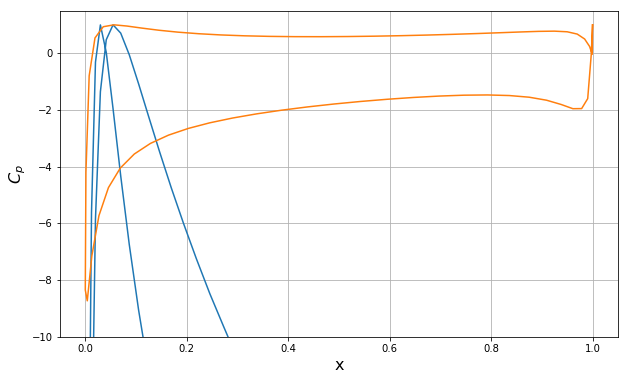

In [599]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels[:N]], [panel.cp for panel in panels[:N]])
plt.plot(x_main_theory, cp_main_theory)
plt.ylim(-10, 1.5);

In [600]:
sum(panel.sigma*panel.length for panel in panels)

-0.68697380337413572

In [601]:
x_flap_theory, cp_flap_theory = np.loadtxt(open('Cp_Flap_theoretical.csv', 'r'), delimiter=',', dtype=float, unpack=True)

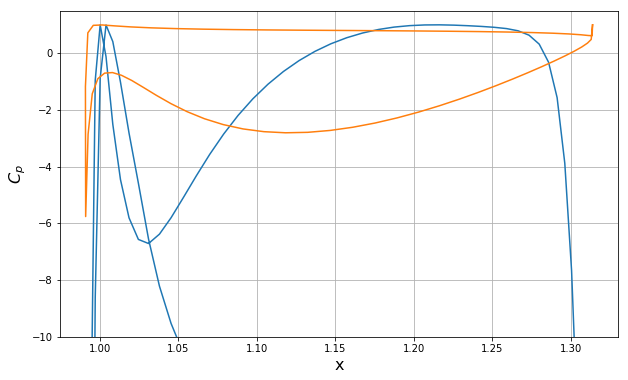

In [602]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels[N:]], [panel.cp for panel in panels[N:]])
plt.plot(x_flap_theory, cp_flap_theory)
plt.ylim(-10, 1.5);